In [1]:
import matplotlib.pyplot as plt
from numba import prange
from numba import cuda
import numpy as np
import numba
import math

# Uniform attenuation
attenuation = np.ones((128, 128, 128), dtype=np.float32)

# Generate random LORs (for demonstration - replace with your simulated LORs)
n_lors = 1_000_000  # Use smaller number for testing
lors = np.random.randn(n_lors, 6).astype(np.float32) * 50  # Random LORs
    

Generating example data...
Computing sensitivity map...
  Processed 100000/1000000 LORs
  Processed 200000/1000000 LORs
  Processed 300000/1000000 LORs
  Processed 400000/1000000 LORs
  Processed 500000/1000000 LORs
  Processed 600000/1000000 LORs
  Processed 700000/1000000 LORs
  Processed 800000/1000000 LORs
  Processed 900000/1000000 LORs
  Processed 1000000/1000000 LORs
Starting OSEM: 3 iterations, 10 subsets
Total LORs: 1000000, LORs per subset: 100000
Iteration 1/3
  Subset 1/10 complete
  Subset 2/10 complete
  Subset 3/10 complete
  Subset 4/10 complete
  Subset 5/10 complete
  Subset 6/10 complete
  Subset 7/10 complete
  Subset 8/10 complete
  Subset 9/10 complete
  Subset 10/10 complete
Iteration 2/3
  Subset 1/10 complete
  Subset 2/10 complete
  Subset 3/10 complete
  Subset 4/10 complete
  Subset 5/10 complete
  Subset 6/10 complete
  Subset 7/10 complete
  Subset 8/10 complete
  Subset 9/10 complete
  Subset 10/10 complete
Iteration 3/3
  Subset 1/10 complete
  Subset 2/

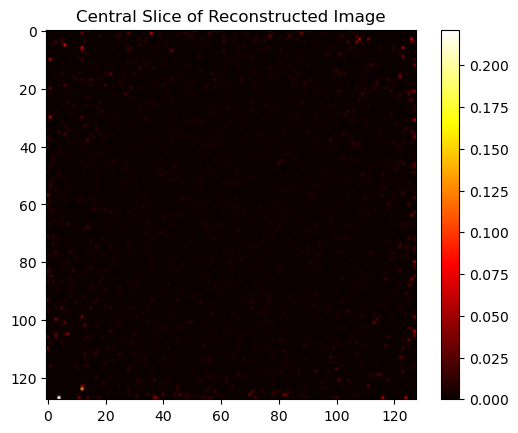

In [2]:


@numba.jit(nopython=True)
def siddon(x1, y1, z1, x2, y2, z2, grid_size, voxel_size, grid_origin):
    """
    Siddon's algorithm for ray-voxel intersection.
    Returns arrays of voxel indices and intersection lengths.
    
    Parameters:
    - (x1,y1,z1), (x2,y2,z2): LOR endpoints in mm
    - grid_size: tuple (nx, ny, nz) - number of voxels
    - voxel_size: float - voxel dimension in mm
    - grid_origin: tuple (x0, y0, z0) - grid minimum corner in mm
    
    Returns:
    - voxel_indices: array of linear indices
    - lengths: array of intersection lengths in mm
    - count: number of intersected voxels
    """
    nx, ny, nz = grid_size
    x0, y0, z0 = grid_origin
    
    # Direction vector
    dx = x2 - x1
    dy = y2 - y1
    dz = z2 - z1
    
    # Ray length
    ray_length = np.sqrt(dx*dx + dy*dy + dz*dz)
    if ray_length < 1e-10:
        return np.empty(0, dtype=np.int32), np.empty(0, dtype=np.float32), 0
    
    # Normalize direction
    dx /= ray_length
    dy /= ray_length
    dz /= ray_length
    
    # Compute parametric t values for grid boundaries
    # X boundaries
    if abs(dx) > 1e-10:
        tx_min = (x0 - x1) / dx
        tx_max = (x0 + nx * voxel_size - x1) / dx
        if tx_min > tx_max:
            tx_min, tx_max = tx_max, tx_min
    else:
        tx_min = -1e10
        tx_max = 1e10
    
    # Y boundaries
    if abs(dy) > 1e-10:
        ty_min = (y0 - y1) / dy
        ty_max = (y0 + ny * voxel_size - y1) / dy
        if ty_min > ty_max:
            ty_min, ty_max = ty_max, ty_min
    else:
        ty_min = -1e10
        ty_max = 1e10
    
    # Z boundaries
    if abs(dz) > 1e-10:
        tz_min = (z0 - z1) / dz
        tz_max = (z0 + nz * voxel_size - z1) / dz
        if tz_min > tz_max:
            tz_min, tz_max = tz_max, tz_min
    else:
        tz_min = -1e10
        tz_max = 1e10
    
    # Overall entry and exit parameters
    t_min = max(max(tx_min, ty_min), tz_min)
    t_max = min(min(tx_max, ty_max), tz_max)
    
    # Check if ray intersects grid
    if t_min >= t_max or t_max < 0 or t_min > ray_length:
        return np.empty(0, dtype=np.int32), np.empty(0, dtype=np.float32), 0
    
    # Clip to ray segment
    t_min = max(t_min, 0.0)
    t_max = min(t_max, ray_length)
    
    # Starting position
    x_start = x1 + t_min * dx
    y_start = y1 + t_min * dy
    z_start = z1 + t_min * dz
    
    # Starting voxel indices
    ix = int((x_start - x0) / voxel_size)
    iy = int((y_start - y0) / voxel_size)
    iz = int((z_start - z0) / voxel_size)
    
    # Clamp to grid
    ix = max(0, min(ix, nx - 1))
    iy = max(0, min(iy, ny - 1))
    iz = max(0, min(iz, nz - 1))
    
    # Step directions
    step_x = 1 if dx > 0 else -1
    step_y = 1 if dy > 0 else -1
    step_z = 1 if dz > 0 else -1
    
    # t values for next voxel boundaries
    if abs(dx) > 1e-10:
        if dx > 0:
            t_next_x = ((ix + 1) * voxel_size + x0 - x1) / dx
        else:
            t_next_x = (ix * voxel_size + x0 - x1) / dx
        t_delta_x = voxel_size / abs(dx)
    else:
        t_next_x = 1e10
        t_delta_x = 1e10
    
    if abs(dy) > 1e-10:
        if dy > 0:
            t_next_y = ((iy + 1) * voxel_size + y0 - y1) / dy
        else:
            t_next_y = (iy * voxel_size + y0 - y1) / dy
        t_delta_y = voxel_size / abs(dy)
    else:
        t_next_y = 1e10
        t_delta_y = 1e10
    
    if abs(dz) > 1e-10:
        if dz > 0:
            t_next_z = ((iz + 1) * voxel_size + z0 - z1) / dz
        else:
            t_next_z = (iz * voxel_size + z0 - z1) / dz
        t_delta_z = voxel_size / abs(dz)
    else:
        t_next_z = 1e10
        t_delta_z = 1e10
    
    # Traverse voxels
    max_voxels = nx + ny + nz
    voxel_indices = np.empty(max_voxels, dtype=np.int32)
    lengths = np.empty(max_voxels, dtype=np.float32)
    count = 0
    
    t_current = t_min
    
    while t_current < t_max and count < max_voxels:
        # Determine next boundary crossing
        t_next = min(min(t_next_x, t_next_y), t_next_z)
        t_next = min(t_next, t_max)
        
        # Length in current voxel
        length = t_next - t_current
        
        if length > 1e-10:
            voxel_indices[count] = ix + iy * nx + iz * nx * ny
            lengths[count] = length
            count += 1
        
        # Move to next voxel
        if t_next >= t_max:
            break
        
        if abs(t_next - t_next_x) < 1e-9:
            ix += step_x
            if ix < 0 or ix >= nx:
                break
            t_next_x += t_delta_x
        
        if abs(t_next - t_next_y) < 1e-9:
            iy += step_y
            if iy < 0 or iy >= ny:
                break
            t_next_y += t_delta_y
        
        if abs(t_next - t_next_z) < 1e-9:
            iz += step_z
            if iz < 0 or iz >= nz:
                break
            t_next_z += t_delta_z
        
        t_current = t_next
    
    return voxel_indices[:count], lengths[:count], count


@numba.jit(nopython=True, parallel=True)
def forward_project(lors, image, attenuation, grid_size, voxel_size, grid_origin):
    """
    Forward projection with attenuation weighting.
    
    Returns:
    - expected_counts: array of expected counts for each LOR
    """
    n_lors = lors.shape[0]
    expected = np.zeros(n_lors, dtype=np.float32)
    
    for i in prange(n_lors):
        x1, y1, z1 = lors[i, 0], lors[i, 1], lors[i, 2]
        x2, y2, z2 = lors[i, 3], lors[i, 4], lors[i, 5]
        
        voxels, lengths, count = siddon(x1, y1, z1, x2, y2, z2, 
                                        grid_size, voxel_size, grid_origin)
        
        val = 0.0
        for j in range(count):
            idx = voxels[j]
            val += image[idx] * attenuation[idx] * lengths[j]
        
        expected[i] = val
    
    return expected


@numba.jit(nopython=True)
def backproject_single(lor, ratio, attenuation, backproj, grid_size, voxel_size, grid_origin):
    """
    Backprojection for a single LOR (called serially for thread safety).
    """
    x1, y1, z1 = lor[0], lor[1], lor[2]
    x2, y2, z2 = lor[3], lor[4], lor[5]
    
    voxels, lengths, count = siddon(x1, y1, z1, x2, y2, z2,
                                    grid_size, voxel_size, grid_origin)
    
    for j in range(count):
        idx = voxels[j]
        backproj[idx] += ratio * attenuation[idx] * lengths[j]


def backproject(lors, ratios, attenuation, backproj, grid_size, voxel_size, grid_origin):
    """
    Backprojection with attenuation weighting.
    Serial to avoid race conditions.
    """
    n_lors = lors.shape[0]
    for i in range(n_lors):
        backproject_single(lors[i], ratios[i], attenuation, backproj,
                          grid_size, voxel_size, grid_origin)


@numba.jit(nopython=True)
def compute_sensitivity_single(lor, attenuation, sensitivity, grid_size, voxel_size, grid_origin):
    """
    Compute sensitivity for a single LOR (called serially for thread safety).
    """
    x1, y1, z1 = lor[0], lor[1], lor[2]
    x2, y2, z2 = lor[3], lor[4], lor[5]
    
    voxels, lengths, count = siddon(x1, y1, z1, x2, y2, z2,
                                    grid_size, voxel_size, grid_origin)
    
    for j in range(count):
        idx = voxels[j]
        sensitivity[idx] += attenuation[idx] * lengths[j]


def compute_sensitivity(lors, attenuation, sensitivity, grid_size, voxel_size, grid_origin):
    """
    Compute sensitivity map (normalization factor for OSEM).
    Serial to avoid race conditions.
    """
    n_lors = lors.shape[0]
    for i in range(n_lors):
        compute_sensitivity_single(lors[i], attenuation, sensitivity,
                                  grid_size, voxel_size, grid_origin)
        if (i + 1) % 100000 == 0:
            print(f"  Processed {i + 1}/{n_lors} LORs")


def osem_reconstruct(lors, attenuation, n_subsets=10, n_iterations=5, 
                     grid_size=(128, 128, 128), voxel_size=1.0):
    """
    OSEM reconstruction for PET with attenuation correction.
    
    Parameters:
    - lors: (N, 6) array of LOR endpoints [x1,y1,z1,x2,y2,z2] in mm
    - attenuation: (128,128,128) attenuation map
    - n_subsets: number of ordered subsets
    - n_iterations: number of iterations
    - grid_size: voxel grid dimensions
    - voxel_size: voxel size in mm
    
    Returns:
    - image: reconstructed activity image
    - sensitivity: sensitivity map
    """
    nx, ny, nz = grid_size
    n_voxels = nx * ny * nz
    grid_origin = (-64.0, -64.0, -64.0)  # Grid centered at origin
    
    # Initialize image (uniform)
    image = np.ones(n_voxels, dtype=np.float32)
    
    # Flatten attenuation
    attenuation_flat = attenuation.ravel().astype(np.float32)
    
    # Compute sensitivity map once
    print("Computing sensitivity map...")
    sensitivity = np.zeros(n_voxels, dtype=np.float32)
    compute_sensitivity(lors.astype(np.float32), attenuation_flat, sensitivity,
                       grid_size, voxel_size, grid_origin)
    
    # Avoid division by zero
    sensitivity = np.maximum(sensitivity, 1e-10)
    
    # Subset partitioning
    n_lors = lors.shape[0]
    subset_size = n_lors // n_subsets
    
    print(f"Starting OSEM: {n_iterations} iterations, {n_subsets} subsets")
    print(f"Total LORs: {n_lors}, LORs per subset: {subset_size}")
    
    # Main OSEM loop
    for iteration in range(n_iterations):
        print(f"Iteration {iteration + 1}/{n_iterations}")
        
        for subset in range(n_subsets):
            # Get subset of LORs
            start_idx = subset * subset_size
            end_idx = start_idx + subset_size if subset < n_subsets - 1 else n_lors
            lors_subset = lors[start_idx:end_idx]
            
            # Forward projection
            expected = forward_project(lors_subset.astype(np.float32), image, 
                                      attenuation_flat, grid_size, voxel_size, 
                                      grid_origin)
            
            # Compute ratios (measured = 1 for each LOR in list-mode)
            expected = np.maximum(expected, 1e-10)  # Avoid division by zero
            ratios = 1.0 / expected
            
            # Backprojection
            backproj = np.zeros(n_voxels, dtype=np.float32)
            backproject(lors_subset.astype(np.float32), ratios.astype(np.float32),
                       attenuation_flat, backproj, grid_size, voxel_size, grid_origin)
            
            # Update image
            image *= backproj / sensitivity
            
            print(f"  Subset {subset + 1}/{n_subsets} complete")
    
    # Reshape to 3D
    image_3d = image.reshape(grid_size)
    sensitivity_3d = sensitivity.reshape(grid_size)
    
    return image_3d, sensitivity_3d


# Example usage
if __name__ == "__main__":
    # Generate example data
    print("Generating example data...")
    
    # Create simple phantom (sphere in center)
    phantom = np.zeros((128, 128, 128), dtype=np.float32)
    for i in range(128):
        for j in range(128):
            for k in range(128):
                r = np.sqrt((i-64)**2 + (j-64)**2 + (k-64)**2)
                if r < 30:
                    phantom[i, j, k] = 1.0
    
    # Run OSEM
    reconstructed, sensitivity = osem_reconstruct(lors, attenuation, 
                                                   n_subsets=10, n_iterations=3)
    
    print(f"Reconstruction complete!")
    print(f"Image shape: {reconstructed.shape}")
    print(f"Image range: [{reconstructed.min():.3f}, {reconstructed.max():.3f}]")

    # Display central slice
    plt.imshow(reconstructed[:, :, 64], cmap='hot')
    plt.colorbar()
    plt.title('Central Slice of Reconstructed Image')

Checking CUDA availability...
CUDA available: True
GPU: NVIDIA GeForce RTX 2080 Ti

Generating example data...
Computing sensitivity map on GPU...
  Processed 1000000/1000000 LORs

Starting OSEM on GPU: 3 iterations, 10 subsets
Total LORs: 1000000, LORs per subset: 100000
Batch size: 1000000

Iteration 1/3
  Subset 1/10 complete
  Subset 2/10 complete
  Subset 3/10 complete
  Subset 4/10 complete
  Subset 5/10 complete
  Subset 6/10 complete
  Subset 7/10 complete
  Subset 8/10 complete
  Subset 9/10 complete
  Subset 10/10 complete

Iteration 2/3
  Subset 1/10 complete
  Subset 2/10 complete
  Subset 3/10 complete
  Subset 4/10 complete
  Subset 5/10 complete
  Subset 6/10 complete
  Subset 7/10 complete
  Subset 8/10 complete
  Subset 9/10 complete
  Subset 10/10 complete

Iteration 3/3
  Subset 1/10 complete
  Subset 2/10 complete
  Subset 3/10 complete
  Subset 4/10 complete
  Subset 5/10 complete
  Subset 6/10 complete
  Subset 7/10 complete
  Subset 8/10 complete
  Subset 9/10 co

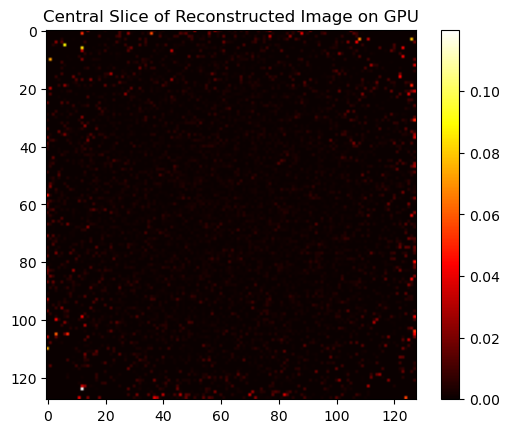

In [3]:
@cuda.jit(device=True)
def siddon_cuda(x1, y1, z1, x2, y2, z2, grid_size, voxel_size, grid_origin,
                voxel_indices, lengths):
    """
    Siddon's algorithm for CUDA (device function).
    Returns count of intersected voxels.
    Arrays voxel_indices and lengths must be preallocated.
    """
    nx, ny, nz = grid_size
    x0, y0, z0 = grid_origin
    
    # Direction vector
    dx = x2 - x1
    dy = y2 - y1
    dz = z2 - z1
    
    # Ray length
    ray_length = math.sqrt(dx*dx + dy*dy + dz*dz)
    if ray_length < 1e-10:
        return 0
    
    # Normalize direction
    dx /= ray_length
    dy /= ray_length
    dz /= ray_length
    
    # Compute parametric t values for grid boundaries
    if abs(dx) > 1e-10:
        tx_min = (x0 - x1) / dx
        tx_max = (x0 + nx * voxel_size - x1) / dx
        if tx_min > tx_max:
            tx_min, tx_max = tx_max, tx_min
    else:
        tx_min = -1e10
        tx_max = 1e10
    
    if abs(dy) > 1e-10:
        ty_min = (y0 - y1) / dy
        ty_max = (y0 + ny * voxel_size - y1) / dy
        if ty_min > ty_max:
            ty_min, ty_max = ty_max, ty_min
    else:
        ty_min = -1e10
        ty_max = 1e10
    
    if abs(dz) > 1e-10:
        tz_min = (z0 - z1) / dz
        tz_max = (z0 + nz * voxel_size - z1) / dz
        if tz_min > tz_max:
            tz_min, tz_max = tz_max, tz_min
    else:
        tz_min = -1e10
        tz_max = 1e10
    
    # Overall entry and exit
    t_min = max(max(tx_min, ty_min), tz_min)
    t_max = min(min(tx_max, ty_max), tz_max)
    
    if t_min >= t_max or t_max < 0 or t_min > ray_length:
        return 0
    
    t_min = max(t_min, 0.0)
    t_max = min(t_max, ray_length)
    
    # Starting position
    x_start = x1 + t_min * dx
    y_start = y1 + t_min * dy
    z_start = z1 + t_min * dz
    
    # Starting voxel
    ix = int((x_start - x0) / voxel_size)
    iy = int((y_start - y0) / voxel_size)
    iz = int((z_start - z0) / voxel_size)
    
    ix = max(0, min(ix, nx - 1))
    iy = max(0, min(iy, ny - 1))
    iz = max(0, min(iz, nz - 1))
    
    # Step directions
    step_x = 1 if dx > 0 else -1
    step_y = 1 if dy > 0 else -1
    step_z = 1 if dz > 0 else -1
    
    # Next boundary t values
    if abs(dx) > 1e-10:
        if dx > 0:
            t_next_x = ((ix + 1) * voxel_size + x0 - x1) / dx
        else:
            t_next_x = (ix * voxel_size + x0 - x1) / dx
        t_delta_x = voxel_size / abs(dx)
    else:
        t_next_x = 1e10
        t_delta_x = 1e10
    
    if abs(dy) > 1e-10:
        if dy > 0:
            t_next_y = ((iy + 1) * voxel_size + y0 - y1) / dy
        else:
            t_next_y = (iy * voxel_size + y0 - y1) / dy
        t_delta_y = voxel_size / abs(dy)
    else:
        t_next_y = 1e10
        t_delta_y = 1e10
    
    if abs(dz) > 1e-10:
        if dz > 0:
            t_next_z = ((iz + 1) * voxel_size + z0 - z1) / dz
        else:
            t_next_z = (iz * voxel_size + z0 - z1) / dz
        t_delta_z = voxel_size / abs(dz)
    else:
        t_next_z = 1e10
        t_delta_z = 1e10
    
    # Traverse voxels
    count = 0
    t_current = t_min
    max_voxels = len(voxel_indices)
    
    while t_current < t_max and count < max_voxels:
        t_next = min(min(t_next_x, t_next_y), t_next_z)
        t_next = min(t_next, t_max)
        
        length = t_next - t_current
        
        if length > 1e-10:
            voxel_indices[count] = ix + iy * nx + iz * nx * ny
            lengths[count] = length
            count += 1
        
        if t_next >= t_max:
            break
        
        if abs(t_next - t_next_x) < 1e-9:
            ix += step_x
            if ix < 0 or ix >= nx:
                break
            t_next_x += t_delta_x
        
        if abs(t_next - t_next_y) < 1e-9:
            iy += step_y
            if iy < 0 or iy >= ny:
                break
            t_next_y += t_delta_y
        
        if abs(t_next - t_next_z) < 1e-9:
            iz += step_z
            if iz < 0 or iz >= nz:
                break
            t_next_z += t_delta_z
        
        t_current = t_next
    
    return count


@cuda.jit
def forward_project_kernel(lors, image, attenuation, expected, 
                          nx, ny, nz, voxel_size, x0, y0, z0):
    """
    CUDA kernel for forward projection.
    Each thread processes one LOR.
    """
    idx = cuda.grid(1)
    
    if idx >= lors.shape[0]:
        return
    
    # Allocate shared arrays for this thread
    voxels = cuda.local.array(200, numba.int32)
    lens = cuda.local.array(200, numba.float32)
    
    x1 = lors[idx, 0]
    y1 = lors[idx, 1]
    z1 = lors[idx, 2]
    x2 = lors[idx, 3]
    y2 = lors[idx, 4]
    z2 = lors[idx, 5]
    
    count = siddon_cuda(x1, y1, z1, x2, y2, z2, 
                       (nx, ny, nz), voxel_size, (x0, y0, z0),
                       voxels, lens)
    
    val = 0.0
    for i in range(count):
        v_idx = voxels[i]
        val += image[v_idx] * attenuation[v_idx] * lens[i]
    
    expected[idx] = val


@cuda.jit
def backproject_kernel(lors, ratios, attenuation, backproj,
                      nx, ny, nz, voxel_size, x0, y0, z0):
    """
    CUDA kernel for backprojection.
    Uses atomic add for thread safety.
    """
    idx = cuda.grid(1)
    
    if idx >= lors.shape[0]:
        return
    
    voxels = cuda.local.array(200, numba.int32)
    lens = cuda.local.array(200, numba.float32)
    
    x1 = lors[idx, 0]
    y1 = lors[idx, 1]
    z1 = lors[idx, 2]
    x2 = lors[idx, 3]
    y2 = lors[idx, 4]
    z2 = lors[idx, 5]
    
    count = siddon_cuda(x1, y1, z1, x2, y2, z2,
                       (nx, ny, nz), voxel_size, (x0, y0, z0),
                       voxels, lens)
    
    ratio = ratios[idx]
    for i in range(count):
        v_idx = voxels[i]
        val = ratio * attenuation[v_idx] * lens[i]
        cuda.atomic.add(backproj, v_idx, val)


@cuda.jit
def sensitivity_kernel(lors, attenuation, sensitivity,
                      nx, ny, nz, voxel_size, x0, y0, z0):
    """
    CUDA kernel for sensitivity computation.
    """
    idx = cuda.grid(1)
    
    if idx >= lors.shape[0]:
        return
    
    voxels = cuda.local.array(200, numba.int32)
    lens = cuda.local.array(200, numba.float32)
    
    x1 = lors[idx, 0]
    y1 = lors[idx, 1]
    z1 = lors[idx, 2]
    x2 = lors[idx, 3]
    y2 = lors[idx, 4]
    z2 = lors[idx, 5]
    
    count = siddon_cuda(x1, y1, z1, x2, y2, z2,
                       (nx, ny, nz), voxel_size, (x0, y0, z0),
                       voxels, lens)
    
    for i in range(count):
        v_idx = voxels[i]
        val = attenuation[v_idx] * lens[i]
        cuda.atomic.add(sensitivity, v_idx, val)


def forward_project_gpu(lors, image, attenuation, grid_size, voxel_size, 
                       grid_origin, batch_size=100000):
    """
    Forward projection on GPU with batching.
    """
    n_lors = lors.shape[0]
    n_voxels = np.prod(grid_size)
    expected = np.zeros(n_lors, dtype=np.float32)
    
    # Transfer image and attenuation to GPU once
    d_image = cuda.to_device(image.astype(np.float32))
    d_attenuation = cuda.to_device(attenuation.astype(np.float32))
    
    nx, ny, nz = grid_size
    x0, y0, z0 = grid_origin
    
    # Process in batches
    threads_per_block = 256
    
    for start_idx in range(0, n_lors, batch_size):
        end_idx = min(start_idx + batch_size, n_lors)
        batch_lors = lors[start_idx:end_idx]
        n_batch = batch_lors.shape[0]
        
        # Transfer batch to GPU
        d_lors = cuda.to_device(batch_lors.astype(np.float32))
        d_expected = cuda.device_array(n_batch, dtype=np.float32)
        
        # Launch kernel
        blocks_per_grid = (n_batch + threads_per_block - 1) // threads_per_block
        forward_project_kernel[blocks_per_grid, threads_per_block](
            d_lors, d_image, d_attenuation, d_expected,
            nx, ny, nz, voxel_size, x0, y0, z0
        )
        
        # Copy back
        expected[start_idx:end_idx] = d_expected.copy_to_host()
    
    return expected


def backproject_gpu(lors, ratios, attenuation, grid_size, voxel_size,
                   grid_origin, batch_size=100000):
    """
    Backprojection on GPU with batching.
    """
    n_lors = lors.shape[0]
    n_voxels = np.prod(grid_size)
    backproj = np.zeros(n_voxels, dtype=np.float32)
    
    # GPU arrays
    d_attenuation = cuda.to_device(attenuation.astype(np.float32))
    d_backproj = cuda.to_device(backproj)
    
    nx, ny, nz = grid_size
    x0, y0, z0 = grid_origin
    
    threads_per_block = 256
    
    for start_idx in range(0, n_lors, batch_size):
        end_idx = min(start_idx + batch_size, n_lors)
        batch_lors = lors[start_idx:end_idx]
        batch_ratios = ratios[start_idx:end_idx]
        n_batch = batch_lors.shape[0]
        
        d_lors = cuda.to_device(batch_lors.astype(np.float32))
        d_ratios = cuda.to_device(batch_ratios.astype(np.float32))
        
        blocks_per_grid = (n_batch + threads_per_block - 1) // threads_per_block
        backproject_kernel[blocks_per_grid, threads_per_block](
            d_lors, d_ratios, d_attenuation, d_backproj,
            nx, ny, nz, voxel_size, x0, y0, z0
        )
    
    return d_backproj.copy_to_host()


def compute_sensitivity_gpu(lors, attenuation, grid_size, voxel_size,
                           grid_origin, batch_size=100000):
    """
    Compute sensitivity map on GPU with batching.
    """
    n_lors = lors.shape[0]
    n_voxels = np.prod(grid_size)
    sensitivity = np.zeros(n_voxels, dtype=np.float32)
    
    d_attenuation = cuda.to_device(attenuation.astype(np.float32))
    d_sensitivity = cuda.to_device(sensitivity)
    
    nx, ny, nz = grid_size
    x0, y0, z0 = grid_origin
    
    threads_per_block = 256
    
    for start_idx in range(0, n_lors, batch_size):
        end_idx = min(start_idx + batch_size, n_lors)
        batch_lors = lors[start_idx:end_idx]
        n_batch = batch_lors.shape[0]
        
        d_lors = cuda.to_device(batch_lors.astype(np.float32))
        
        blocks_per_grid = (n_batch + threads_per_block - 1) // threads_per_block
        sensitivity_kernel[blocks_per_grid, threads_per_block](
            d_lors, d_attenuation, d_sensitivity,
            nx, ny, nz, voxel_size, x0, y0, z0
        )
        
        if (end_idx) % 1000000 == 0 or end_idx == n_lors:
            print(f"  Processed {end_idx}/{n_lors} LORs")
    
    return d_sensitivity.copy_to_host()


def osem_reconstruct_gpu(lors, attenuation, n_subsets=10, n_iterations=5,
                        grid_size=(128, 128, 128), voxel_size=1.0,
                        batch_size=100000):
    """
    OSEM reconstruction for PET on GPU.
    
    Parameters:
    - lors: (N, 6) array of LOR endpoints [x1,y1,z1,x2,y2,z2] in mm
    - attenuation: (128,128,128) attenuation map
    - n_subsets: number of ordered subsets
    - n_iterations: number of iterations
    - grid_size: voxel grid dimensions
    - voxel_size: voxel size in mm
    - batch_size: LORs per GPU batch (adjust based on GPU memory)
    
    Returns:
    - image: reconstructed activity image
    - sensitivity: sensitivity map
    """
    nx, ny, nz = grid_size
    n_voxels = nx * ny * nz
    grid_origin = (-64.0, -64.0, -64.0)
    
    # Initialize
    image = np.ones(n_voxels, dtype=np.float32)
    attenuation_flat = attenuation.ravel().astype(np.float32)
    
    # Compute sensitivity
    print("Computing sensitivity map on GPU...")
    sensitivity = compute_sensitivity_gpu(lors, attenuation_flat, grid_size,
                                         voxel_size, grid_origin, batch_size)
    sensitivity = np.maximum(sensitivity, 1e-10)
    
    # Subset partitioning
    n_lors = lors.shape[0]
    subset_size = n_lors // n_subsets
    
    print(f"\nStarting OSEM on GPU: {n_iterations} iterations, {n_subsets} subsets")
    print(f"Total LORs: {n_lors}, LORs per subset: {subset_size}")
    print(f"Batch size: {batch_size}")
    
    # OSEM loop
    for iteration in range(n_iterations):
        print(f"\nIteration {iteration + 1}/{n_iterations}")
        
        for subset in range(n_subsets):
            start_idx = subset * subset_size
            end_idx = start_idx + subset_size if subset < n_subsets - 1 else n_lors
            lors_subset = lors[start_idx:end_idx]
            
            # Forward projection
            expected = forward_project_gpu(lors_subset, image, attenuation_flat,
                                          grid_size, voxel_size, grid_origin,
                                          batch_size)
            
            # Compute ratios
            expected = np.maximum(expected, 1e-10)
            ratios = 1.0 / expected
            
            # Backprojection
            backproj = backproject_gpu(lors_subset, ratios, attenuation_flat,
                                      grid_size, voxel_size, grid_origin,
                                      batch_size)
            
            # Update image
            image *= backproj / sensitivity
            
            print(f"  Subset {subset + 1}/{n_subsets} complete")
    
    image_3d = image.reshape(grid_size)
    sensitivity_3d = sensitivity.reshape(grid_size)
    
    return image_3d, sensitivity_3d


# Example usage
if __name__ == "__main__":
    print("Checking CUDA availability...")
    print(f"CUDA available: {cuda.is_available()}")
    if cuda.is_available():
        print(f"GPU: {cuda.get_current_device().name.decode()}")
    
    # Generate example data
    print("\nGenerating example data...")
    
    # Simple phantom
    phantom = np.zeros((128, 128, 128), dtype=np.float32)
    for i in range(128):
        for j in range(128):
            for k in range(128):
                r = np.sqrt((i-64)**2 + (j-64)**2 + (k-64)**2)
                if r < 30:
                    phantom[i, j, k] = 1.0
    
    # Run OSEM on GPU
    reconstructed, sensitivity = osem_reconstruct_gpu(
        lors, attenuation,
        n_subsets=10,
        n_iterations=3,
        batch_size=1000000  # Adjust if you get memory errors
    )
    
    print(f"\nReconstruction complete!")
    print(f"Image shape: {reconstructed.shape}")
    print(f"Image range: [{reconstructed.min():.3f}, {reconstructed.max():.3f}]")

    # Display central slice
    import matplotlib.pyplot as plt

    plt.imshow(reconstructed[:, :, 64], cmap='hot')
    plt.colorbar()
    plt.title('Central Slice of Reconstructed Image on GPU')
